# Step 1: Install 'sentinelhub' package

Install these packages if you haven't done so.

In [ ]:
#!pip install sentinelhub
#!pip install utils
# !pip install imageio
#!pip install rasterio

In [188]:
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# Step 2: Configuration

Before we can start downloading images, we need to set up our Sentinel Hub account and get out instance ID and OAuth client credentials.

To create an account, follow the steps below:
1. Go to this website: https://www.sentinel-hub.com/
2. Click Sign up
3. Enter details
4. Verify your email address
5. In your account, go to **Settings** in your Profile 
5. Create **OAuth clients** by entering your 'Client name' (I just write LCLU Mapping) and selecting Client Credentials in the dropdown menu for 'Supported Flow'
7. You will then see your **Client ID** and **Client Secret**. Copy both and save them in your Jupyter Notebook or somewhere as we will use these two to authenticate.
8. Lasltly, go to **Configuration Utility** and select **Simple WMS template** and copy ID from **Service endpoints**. This ID is your **instance ID** which will be your final authentication.

In [5]:
from sentinelhub import SHConfig

instanceID = 'instance_id'
clientID = 'client_id'
clientSecret = 'client_secret'

config = SHConfig()

config.instance_id = instanceID
config.sh_client_id = clientID
config.sh_client_secret = clientSecret
config.save()


# Step 3: Define Area of Interest

We need to define the geographical area for which we want to download images. 

I use this website to specify my area of interest: https://geojson.io/#map=2/0/20

Simply draw a square on the area you want to download its image, and save the location as a 'Geojson' file. 

You will need to read this Geojson file with *Geopandas* package to get the coordinates of the area you selected based on the polygon or 'bounding box' as it has 4 points covering your area of interest.

In [12]:
import geopandas as gpd

# Load GeoJSON file into a GeoDataFrame
gdf = gpd.read_file('area_of_interest.geojson')

# Print the GeoDataFrame
print(gdf)

                                            geometry
0  POLYGON ((101.27184 2.93157, 101.27184 2.84654...


In [14]:
# Extract the bounding box (min_lon, min_lat, max_lon, max_lat)
bbox = gdf.total_bounds 
print("Bounding box:", bbox)


Bounding box: [101.27183878   2.84654219 101.36216612   2.93157359]


In [18]:
# Display the Area of Interest
import folium

# Create a map centered around an average location (uses the first feature's centroid)
centroid = gdf.geometry[0].centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=12)

# Add GeoJSON to folium map
folium.GeoJson(gdf).add_to(m)

# Display the map
m

We are going to have to convert the list of coordinates ('bbox' variable) into a tuple data type as the Sentinel Hub bbox object requires this type of data format.

In [ ]:
# Use the bounding box with SentinelHub
from sentinelhub import BBox, CRS, bbox_to_dimensions

# Define the BBox object
resolution = 60
bbox_values = tuple(bbox) # Ensure the bounding box is a tuple, not a list
sentinel_bbox = BBox(bbox=bbox_values, crs=CRS.WGS84)
sentinel_size = bbox_to_dimensions(sentinel_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {sentinel_size} pixels")

# Step 4: Specify the Data Request

We will now need to specify the type of data we want to download, such as the specific satellite bands, resolution, and time period.

Here we are going to use basic red, Green, and Blue bands to get the true colour image - i.e., the same colour as we see with our naked eyes. 

In [ ]:
# To download image with clouds removed by replacing the clouds pixels with black pixels

# evalscript_rgb = """
# //VERSION=3
# function setup() {
#   return {
#     input: ["B02", "B03", "B04", "SCL"],
#     output: { bands: 3, sampleType: "UINT8" }
#   };
# }
# function evaluatePixel(sample) {
#   if (sample.SCL === 3 || sample.SCL === 9 || sample.SCL === 10) {  // Masking cloud shadows (3), clouds (9), and cirrus (10)
#     return [0, 0, 0];  // Returning black for cloud pixels
#   }

#   // Normalizing factor to convert reflectance to 0-255 scale
#   var scale = 0.5;  // Adjust this factor based on your data's actual range

#   var red = sample.B04 * 2550 * scale;
#   var green = sample.B03 * 2550 * scale;
#   var blue = sample.B02 * 2550 * scale;

#   // Clamping the values to 255 to avoid overflow
#   red = red > 255 ? 255 : red;
#   green = green > 255 ? 255 : green;
#   blue = blue > 255 ? 255 : blue;

#   return [red, green, blue];
# }
# """

In [160]:
from sentinelhub import DataCollection, MimeType, SentinelHubRequest, DownloadRequest, SHConfig
from datetime import datetime

# Define the time interval
time_interval = ('2022-01-01', '2024-04-15')

# Set up download request for an RGB image
evalscript_rgb = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3, sampleType: "UINT8" }
  };
}
function evaluatePixel(sample) {
  // Normalizing factor to convert reflectance to 0-255 scale
  // Typically, reflectance values are in the range 0-1, so multiply by 2550 if reflectance is in 0.0-0.1 range
  // Adjust this factor based on your data's actual range
  var scale = 0.5;  // Scale factor for brightness adjustment

  var red = sample.B04 * 2550 * scale;
  var green = sample.B03 * 2550 * scale;
  var blue = sample.B02 * 2550 * scale;

  // Clamping the values to 255 to avoid overflow
  red = red > 255 ? 255 : red;
  green = green > 255 ? 255 : green;
  blue = blue > 255 ? 255 : blue;

  return [red, green, blue];
}

"""

request = SentinelHubRequest(
  evalscript=evalscript_rgb,
  input_data=[
    SentinelHubRequest.input_data(
      data_collection=DataCollection.SENTINEL2_L2A,
      time_interval=time_interval,
        maxcc=0.1
    )
  ],
  responses=[
    SentinelHubRequest.output_response('default', MimeType.PNG)
  ],
  bbox=sentinel_bbox,
  size=(512, 512),  # Image size
  config=config
)



# Step 5: Execute the Request and Save the Image

In [162]:
rgb_image = request.get_data()

In [94]:
print(f"Returned data is of type = {type(rgb_image)} and length {len(rgb_image)}.")
print(f"Single element in the list is of type {type(rgb_image[-1])} and has shape {rgb_image[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (512, 512, 3)


In [164]:
image = rgb_image[0]
print(f"Image type: {image.dtype}")

Image type: uint8


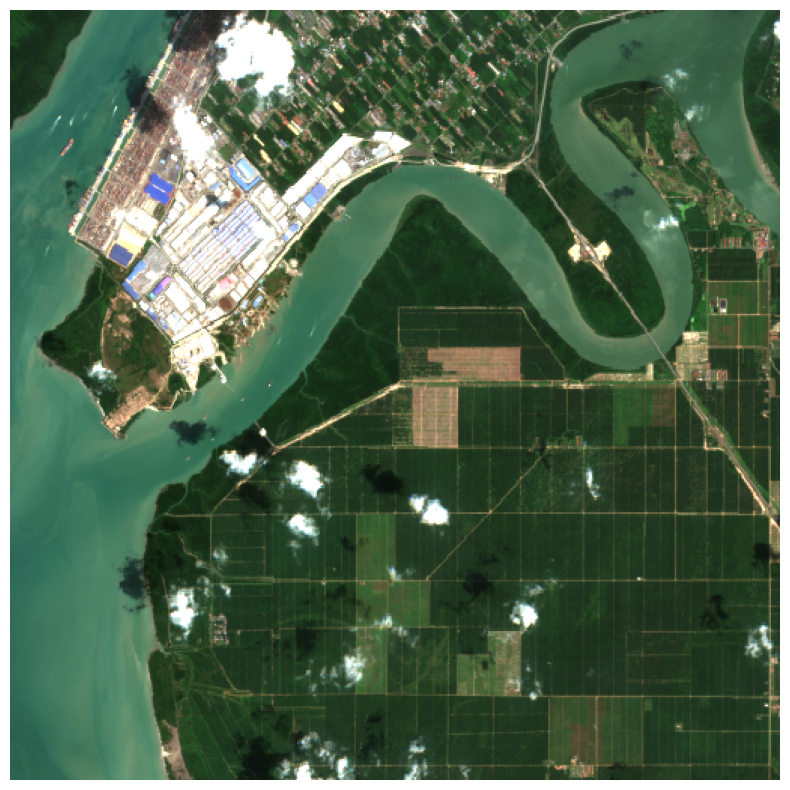

In [166]:
# View the image

import matplotlib.pyplot as plt

# Show the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


As we can see, our image still has some clouds because we have specified a range of cloud coverage within the request string above i.e., 1 - 10 %.

In [ ]:
# Save the image
import imageio

imageio.imwrite('Images/cloud_masked_image.png', image)

# Adding Cloud Mask data

Let's try to download image with cloud-masked where the pixels corresponding to clouds are masked or hidden.
We will also increase the brightness of the image to improve pixels for classification later.

Just specify the evaluation script and plug this into the 'SentinelHubRequest' along with the type of Sentinel 2 data product (i.e., SENTINEL2_L1C), and the time interval within which the images were captured by the satellite.

In [174]:
evalscript_clm = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04", "CLM"],
    output: { bands: 3 }
  }
}

function evaluatePixel(sample) {
  if (sample.CLM == 1) {
    return [0.75 + sample.B04, sample.B03, sample.B02]
  }
  return [3*sample.B04, 3*sample.B03, 3*sample.B02];
}
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_clm,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=sentinel_bbox,
    size=(512, 512),
    config=config,
)

In [176]:
data_with_cloud_mask = request_true_color.get_data()

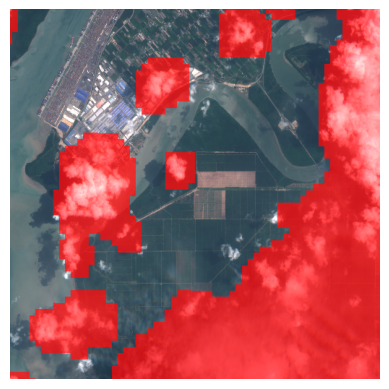

In [178]:
image = data_with_cloud_mask[0]  # The first image in the retrieved data
plt.imshow(image)
plt.axis('off')
plt.show()

As we can see here, the clouds are now masked. But this is not really useful, I want to download an image with no clouds and improved brightness for classification later. 

To do this, we will get cloud-masked data from multiple time periods and combine these images into one, which is known as a **composite image**. The technique to create this type of image is called **mosaicking**.

In [76]:
# Save the cloud masked image

imageio.imwrite('Images/cloud_masked_image.png', image)

# True color mosaic of least cloudy acquisitions

This is a cloud-masked data where clouds are replaced with actual underlying earth imagery from a different time (to fill in the clouded areas) directly using the Sentinel Hub API. To download this type of data, we combine images from multiple dates - a technique known as **mosaicking** or using **multi-temporal composites**.

We will use this image for the classification task as it looks better than any of the above since it is cloud-free.



In [208]:

evalscript_true_color = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3, sampleType: "UINT8" }
  };
}
function evaluatePixel(sample) {
  // Normalizing factor to convert reflectance to 0-255 scale
  // Typically, reflectance values are in the range 0-1, so multiply by 2550 if reflectance is in 0.0-0.1 range
  // Adjust this factor based on your data's actual range
  var scale = 0.5;  // Scale factor for brightness adjustment

  var red = sample.B04 * 2550 * scale;
  var green = sample.B03 * 2550 * scale;
  var blue = sample.B02 * 2550 * scale;

  // Clamping the values to 255 to avoid overflow
  red = red > 255 ? 255 : red;
  green = green > 255 ? 255 : green;
  blue = blue > 255 ? 255 : blue;

  return [red, green, blue];
}

"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=sentinel_bbox,
    size=(512, 512),
    config=config,
)

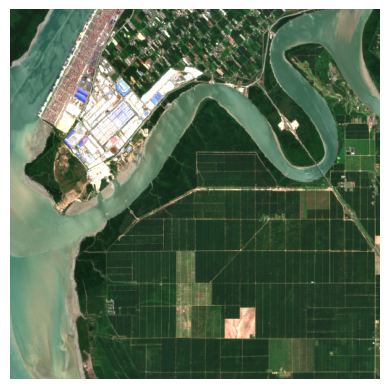

In [210]:
image = request_true_color.get_data()[0]  # The first image in the retrieved data
plt.imshow(image)
plt.axis('off')
plt.show()

As we can see here, the image is definitely looking the best out of all other images. There is no cloud in this image, which will improve our classification later. 


In [212]:
imageio.imwrite('Images/true_colour_mosaic_image.png', image)

# Dowload multiple bands for classification

We are now going to enrich the image with multiple bands suitable for classifying different land cover types.

The following spectral are more effective to capture different land cover types (such as vegetation, water, soil, urban areas):

1. **B02 (Blue)**: Useful for coastal and atmospheric studies.
2. **B03 (Green)**: Helps in analyzing vegetation health.
3. **B04 (Red)**: Crucial for vegetation detection and health.
4. **B08 (NIR - Near Infrared)**: Excellent for vegetation health and separation between vegetation and other types of land cover.
5. **B11 and B12 (SWIR - Short-Wave Infrared)**: Important for moisture content, which is useful for vegetation classification and also for differentiating between clouds and snow.

However, we will download all spectral bands and specify later for classification task.

In [328]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

request_all_bands = SentinelHubRequest(
    data_folder = "Data",
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=sentinel_bbox,
    size=(512, 512),
    config=config,
)

In [330]:
all_bands_response = request_all_bands.get_data(save_data=True)


In [334]:
import os

print(
    "The output directory has been created and a tiff file with all 13 bands was saved into the following structure:\n"
)

for folder, _, filenames in os.walk(request_all_bands.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

The output directory has been created and a tiff file with all 13 bands was saved into the following structure:

Data\84adf81eb4ae349dc1f28833fabdf54b\request.json
Data\84adf81eb4ae349dc1f28833fabdf54b\response.tiff


In [295]:
# import rasterio
# from rasterio.transform import from_origin

# # Assuming `data` is the list of arrays you obtained from the request
# # Each element in `data` is a NumPy array corresponding to a band
# image_data = all_bands_response[0]  # If data contains more than one image, focus on the first one

# # You need to specify the transform and CRS, which are necessary for georeferenced TIFFs
# transform = from_origin(101.27183878, 2.93157359, 10, 10)  # Placeholder values, adjust accordingly

# # Define metadata for the TIFF file
# meta = {
#     'driver': 'GTiff',
#     'dtype': 'uint16',  # Ensure this matches the dtype of your image_data (uint8, uint16, etc.)
#     'nodata': None,
#     'width': image_data.shape[2],
#     'height': image_data.shape[1],
#     'count': image_data.shape[0],  # Number of bands
#     'crs': '+proj=latlong',  # This is a placeholder, specify the correct CRS
#     'transform': transform
# }

# # Write data to a TIFF file
# with rasterio.open('output_image.tif', 'w', **meta) as dst:
#     for i in range(1, image_data.shape[0] + 1):
#         dst.write(image_data[i - 1], i)  # Write each band to the file
